In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

## 1 - Load the training data

In [2]:
file_path = os.path.join('..', 'data', 'cleaned')

train_df = pd.read_csv(os.path.join(file_path, 'train.csv'), low_memory=False)
train_df.head()

,file,VMONTH,VYEAR,VDAYR,YEAR,AGE,SEX,ETHNIC,RACE,USETOBAC,...,PHYSASST,NPNMW,RNLPN,OTHPROV,MHP,NODISP,REFOTHMD,RETAPPT,OTHDISP,ERADMHOS
0,opd2006.csv,December,2006.0,Friday,2006.0,55.0,Male,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No
1,opd2006.csv,November,2006.0,Thursday,2006.0,66.0,Male,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No
2,opd2006.csv,November,2006.0,Wednesday,2006.0,71.0,Female,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,Yes,No,No,No
3,opd2006.csv,November,2006.0,Tuesday,2006.0,1.0,Female,Not Hispanic or Latino,White Only,Not current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No
4,opd2006.csv,November,2006.0,Monday,2006.0,21.0,Female,Not Hispanic or Latino,White Only,Current,...,No,No,No,No,NaN,One or more dispositions marked,No,No,No,No


## 2 - Load the vairiables dictionary and define features for clustering

In [3]:
# Load the variables dictionary
with open(os.path.join(file_path, 'variables.json'), 'r') as f:
    variables = json.load(f)

print(f'Variable Categories:\n')
for category, list in variables.items():
    print(f'{category}')
    print(f'{list}')

Variable Categories:

dateOfVisit
['VMONTH', 'VYEAR', 'VDAYR']
demographics
['AGE', 'AGER', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment
['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason
['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory
['SENBEFOR', 'PASTVIS']
vitalSigns
['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields
['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses
['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses
['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus
['ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
services
['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE


### 2.1 Defining features for clustering

##### !!! The statistical test result of the features should be referred first

In [4]:
train_df[variables['visitReason']].value_counts()

INJDET                          MAJOR                                 RFV1                                 RFV2                       RFV3                                    
None of the above               Chronic problem, routine              Progress visit, NOS                  Psychotherapy              Medication, other and unspecified kinds     43
                                                                      Diabetes mellitus                    Hypertension               Other endocrine, nutritional, and met...    29
Unintentional injury/poisoning  Chronic problem, routine              Alcoholism                           Progress visit, NOS        Psychotherapy                               25
None of the above               Chronic problem, routine              Progress visit, NOS                  Psychotherapy              Group counseling                            23
                                New problem (less than 3 mos. onset)  Fever                          

In [5]:
# Defining the independent variables as features for clustering
features = \
    ['AGE', 'SEX'] + variables['visitReason'] + ['PASTVIS'] + variables['vitalSigns'] \
    + [item for item in variables['presentSymptomsStatus'] if item not in ['NOCHRON', 'TOTCHRON']]

print(f'Features: {features}')
print(f'Number of Features: {len(features)}')

Features: ['AGE', 'SEX', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
Number of Features: 29


In [6]:
clustering_df = train_df.loc[:, features]

## 3 - Preprocess and engineer the features

### 3.1 - Bin/Normalize quantitative features
Need to try out results with Binning

In [7]:
from sklearn.preprocessing import StandardScaler

#### 3.1.1 - Binning

#### 3.1.2 - Normalization

In [8]:
# Get a list of quantitative features
quantitative_features = [feature for feature in features if clustering_df[feature].dtype != 'object']

# Normalize quantitative features
scaler = StandardScaler()
clustering_df[quantitative_features] = scaler.fit_transform(clustering_df[quantitative_features])

# Check the result
clustering_df[quantitative_features].head()

,AGE,PASTVIS,HTIN,WTLB,BMI,TEMPF,BPSYS,BPDIAS
0,0.710117,-0.016688,0.530558,1.762024,1.904835,-0.230443,1.800628,1.390837
1,1.177478,-0.389377,0.609827,0.586196,0.243487,-0.533710,-0.678966,-0.880536
2,1.389914,0.281463,-0.103596,0.329405,0.924274,-1.342420,1.304709,-0.231572
3,-1.584197,-0.389377,-1.926787,-1.670855,NaN,0.881535,NaN,NaN
4,-0.734451,0.281463,0.372019,-0.035507,-0.310296,-0.230443,-0.678966,-1.042777


### 3.2 - Dimensionality reduction for quantitative features

### 3.3 - Encode categorical features

In [9]:
# Get a list of categorical features
categorical_features = [feature for feature in features if feature not in quantitative_features]

# One-hot encode categorical features
clustering_df = pd.get_dummies(clustering_df, columns=categorical_features, drop_first=True)

# Get the list of encoded features
encoded_features = [feature for feature in clustering_df.columns if feature not in quantitative_features + categorical_features]

# Check the result
clustering_df[encoded_features].head()

,SEX_Male,INJDET_Adverse effect of med care/surg care/medicinal drug,INJDET_Injury/poisoning - unknown intent,INJDET_Intentional injury/poisoning,INJDET_None of the above,INJDET_Unintentional injury/poisoning,"MAJOR_Chronic problem, flare-up","MAJOR_Chronic problem, routine",MAJOR_New problem (less than 3 mos. onset),MAJOR_Pre/Post-surgery,...,CHF_Yes,CRF_Yes,COPD_Yes,DEPRN_Yes,DIABETES_Yes,HYPLIPID_Yes,HTN_Yes,IHD_Yes,OBESITY_Yes,OSTPRSIS_Yes
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### 3.4 - Dimensionality reduction for categorical features

### 3.5 - Redefine the clusterring DataFrame for training

In [10]:
# Redefine the clustering DataFrame
clustering_df = clustering_df.loc[:, quantitative_features + encoded_features]

## 4 - Baseline clustering model

### 4.1 - Train models

#### 4.1.1 - KMeans

In [11]:
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [12]:
random_seed = 42

In [13]:
# Impute the missing quantitative values using KNN
n_neighbors = 5
imputer = KNNImputer(n_neighbors=n_neighbors)

clustering_df_imputed = imputer.fit_transform(clustering_df[quantitative_features])

In [14]:
# Concatenate the imputed quantitative features with the encoded categorical features
clustering_df_imputed = pd.concat([
    pd.DataFrame(clustering_df_imputed, columns=quantitative_features), 
    clustering_df[encoded_features]
], axis=1)

In [15]:
# Clustering using KMeans
n_clusters = 10
clustering_model = KMeans(n_clusters=n_clusters, random_state=random_seed)
train_df['cluster'] = clustering_model.fit_predict(clustering_df_imputed)

# Check the result
train_df['cluster'].value_counts()

1    22254
8    15061
9    13645
4    10491
2     9525
0     8824
7     7928
3     6859
6     6335
5     2564
Name: cluster, dtype: int64

In [16]:
# Save the clustering model
clustering_model_path = os.path.join('..', 'models')
clustering_model_name = type(clustering_model).__name__

joblib.dump(clustering_model, os.path.join(clustering_model_path, f'{clustering_model_name}.joblib'))

['../models/KMeans.joblib']

### 4.2 - Evaluation of the model

In [17]:
import altair as alt
import vegafusion as vf
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

#### 4.2.1 - Metrics

In [18]:
# Calculate the Silhouette Score
silhouette = silhouette_score(clustering_df_imputed, train_df['cluster'])
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.06556802884452655


In [19]:
# Calculate the sum of squared distances of samples to their closest cluster center
print(f'Sum of Squared Distances: {clustering_model.inertia_}')

Sum of Squared Distances: 577451.5255316081


#### 4.2.2 - Examine cluster centroids

In [20]:
# Check the cluster centers
cluster_centers = pd.DataFrame(clustering_model.cluster_centers_, columns=clustering_df_imputed.columns)

# Inverse transform the cluster centers
cluster_centers[quantitative_features] = scaler.inverse_transform(cluster_centers[quantitative_features])

# Check the result
cluster_centers

,AGE,PASTVIS,HTIN,WTLB,BMI,TEMPF,BPSYS,BPDIAS,SEX_Male,INJDET_Adverse effect of med care/surg care/medicinal drug,...,CHF_Yes,CRF_Yes,COPD_Yes,DEPRN_Yes,DIABETES_Yes,HYPLIPID_Yes,HTN_Yes,IHD_Yes,OBESITY_Yes,OSTPRSIS_Yes
0,63.166931,4.705802,65.792135,172.697076,28.042684,97.656167,114.675680,64.527969,0.403218,6.686310e-03,...,0.060743,0.036378,0.072303,0.134406,0.241387,0.202403,0.385086,0.076609,0.062670,0.041704
1,43.466160,3.062691,66.529202,190.776532,29.805927,98.044539,126.707487,79.118740,0.426344,3.505303e-03,...,0.007056,0.007909,0.019908,0.161109,0.083094,0.054197,0.139808,0.008089,0.050422,0.006831
2,1.637270,3.039318,30.247811,22.758677,17.538492,98.079607,100.590362,60.259570,0.535853,1.994751e-03,...,0.000840,0.000630,0.009029,0.000735,0.002205,0.000735,0.002835,0.002205,0.006089,0.000210
3,45.710453,3.501910,66.136988,274.798630,43.758233,97.943473,129.803761,76.727657,0.333576,4.665403e-03,...,0.042134,0.016912,0.045196,0.141128,0.337075,0.192448,0.459688,0.039948,0.482723,0.011809
4,26.457535,3.764084,64.523382,160.573406,26.718651,98.049465,111.622953,66.231589,0.059480,3.812792e-04,...,0.000667,0.000667,0.001525,0.049852,0.046802,0.006863,0.024021,0.000763,0.049948,0.002383
5,46.496100,36.786856,65.720905,177.396802,28.472867,97.875757,126.143370,74.599610,0.461778,-1.864828e-17,...,0.019501,0.017551,0.030421,0.306162,0.123245,0.053822,0.193838,0.028081,0.069813,0.014431
6,52.608208,3.097253,66.505478,194.660142,30.824233,97.931441,157.220237,92.850766,0.451144,4.893449e-03,...,0.028887,0.035043,0.044041,0.103552,0.200474,0.164957,0.567798,0.039937,0.108761,0.017837
7,8.076564,2.920610,50.602750,66.117558,17.676780,98.340759,103.271897,61.535217,0.545409,3.405651e-03,...,0.000631,0.002270,0.009082,0.019677,0.011478,0.001892,0.006307,0.001640,0.026110,0.001135
8,24.234349,3.080827,64.888362,148.942203,24.727366,98.009659,113.918011,68.043285,0.361615,3.253004e-03,...,0.001859,0.003519,0.010888,0.123614,0.033791,0.011352,0.030472,0.002523,0.026489,0.001792
9,69.568193,3.667123,65.401642,171.321979,28.222967,97.665419,139.791381,74.557875,0.374863,4.323928e-03,...,0.044558,0.033565,0.059949,0.108904,0.271455,0.231220,0.524954,0.072554,0.051667,0.055845


#### 4.2.3 - Visualization

## 5 - Extract text features from each cluster

#### 5.1 - Aggregate text data by cluster

In [21]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i < 5:
        print(k, v)

dateOfVisit ['VMONTH', 'VYEAR', 'VDAYR']
demographics ['AGE', 'AGER', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment ['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory ['SENBEFOR', 'PASTVIS']


In [22]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i >= 5 and i < 10:
        print(k, v)

vitalSigns ['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields ['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses ['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses ['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus ['ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']


In [23]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i >= 10:
        print(k, v)

services ['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE', 'TEMPTAKE', 'BLODPRES', 'CAM', 'DME', 'HOMEHLTH', 'HOSPICE', 'PT', 'RADTHER', 'SPOCTHER', 'PSYCHOTH', 'OTHMNTL', 'EXCISION', 'WOUND', 'PROC1', 'PROC2', 'PROC3', 'PROC4', 'PROC5', 'PROC6', 'PROC7', 'PROC8', 'PROC9', 'CATSCAN', 'PREGTEST', 'FOOT', 'RETINAL', 'HIVTEST', 'CAST', 'SPLINT']
healthEducation ['ASTHMAED', 'DIETNUTR', 'EXERCISE', 'GRWTHDEV', 'INJPREV', 'STRESMGT', 'TOBACED', 'WTREDUC', 'OTHLTHED']
medicationsAndImmunizations ['MED1', 'MED2', 'MED3', 'MED4', 'MED5', 'MED6', 'MED7', 'MED8', 'NCMED1', 'NCMED2', 'NCMED3', 'NCMED4', 'NCMED5', 'NCMED6', 'NCMED7', 'NCMED8', 'NUMNEW', 'NUMCONT']
providersSeen ['PHYS', 'PHYSASST', 'NPNMW', 'RNLPN', 'OTHPROV', 'MHP']
visitDisposition ['REFOTHMD', 'RETAPPT', 'OTHDISP', '

In [24]:
train_df.USETOBAC.unique()

array(['Not current', 'Current', nan], dtype=object)

In [25]:
train_df[variables['visitReason']].head()

,INJDET,MAJOR,RFV1,RFV2,RFV3
0,Unintentional injury/poisoning,Acute problem,"Injury, other and unspecified, of sho...",NaN,NaN
1,None of the above,Acute problem,Cough,NaN,NaN
2,None of the above,Acute problem,General ill feeling,Abnormal eye movements,NaN
3,None of the above,Acute problem,Other and unspecified symptoms refera...,NaN,NaN
4,None of the above,Acute problem,Throat soreness,Sinus problems,NaN


In [26]:
train_df[variables['vitalSigns']].value_counts()

HTIN  WTLB   BMI    TEMPF  BPSYS  BPDIAS
72.0  165.0  22.38  96.5   130.0  86.0      6
70.0  155.0  22.24  97.1   140.0  88.0      5
64.0  140.0  24.03  97.6   140.0  98.0      4
65.0  132.0  21.96  97.3   140.0  100.0     4
70.0  222.0  31.85  98.4   130.0  88.0      4
                                           ..
63.0  160.0  28.34  97.6   120.0  60.0      1
                    97.5   100.0  60.0      1
                    97.3   130.0  70.0      1
                    97.2   135.0  64.0      1
86.0  279.0  26.52  99.4   155.0  91.0      1
Length: 21999, dtype: int64

In [27]:
train_df[variables['physicianDiagnoses']].head()

,DIAG1,DIAG2,DIAG3
0,"Shoulder and upper arm injury, other ...",NaN,NaN
1,"Bronchitis, not specified as acute or...",NaN,NaN
2,Dizziness and giddiness,"Diabetes mellitus w/o complication, t...",Unspecified essential hypertension
3,Unspecified otitis media,Acute upper respiratory infections of...,Chronic rhinitis
4,Unspecified sinusitis (chronic),NaN,NaN


In [28]:
print(train_df.PRDIAG1.unique())
print()

train_df.DIAG1[train_df.PRDIAG1.str.contains('not probable') | (train_df.PRDIAG1 == 'No')].value_counts()

['No' 'Yes' 'Not applicable' 'Dx is not probable, questionable, ruleout'
 'No diagnosis entered' 'Dx is probable, questionable, or ruleout']



Supervision of other normal pregnancy       3754
Routine infant or child health check        3595
Diabetes mellitus w/o complication, t...    3162
Unspecified essential hypertension          2412
Routine gynecological examination           1496
                                            ... 
Unspecified drug dependence, episodic          1
Delayd/secondary postpartm hemorr pos...       1
Ulcer of esophagus without bleeding            1
Closed fracture of other part of hume...       1
Lacrimal fistula                               1
Name: DIAG1, Length: 4192, dtype: int64

In [29]:
train_df[variables['presentSymptomsStatus']].value_counts()

ARTHRTIS  ASTHMA  CANCER  CASTAGE   CEBVD  CHF  CRF  COPD  DEPRN  DIABETES  HYPLIPID  HTN  IHD  OBESITY  OSTPRSIS
No        No      Yes     Local     No     No   No   No    No     No        No        No   No   No       No          685
                          Distant   No     No   No   No    No     No        No        No   No   No       No          359
                          Regional  No     No   No   No    No     No        No        No   No   No       No          327
                          In situ   No     No   No   No    No     No        No        No   No   No       No          290
                          Local     No     No   No   No    No     No        No        Yes  No   No       No           98
                                                                                                                    ... 
                          Regional  No     No   No   No    Yes    No        Yes       Yes  No   No       No            1
                                       

In [30]:
# Load custom function to combine text features
import sys
sys.path.append('../src/features/')

from combine_textual import combine_features


# Define the list of textual features to combine
textual_features = [
    'AGE', 'SEX', 'USETOBAC', 
    'MAJOR', 'RFV1', 'RFV2', 'RFV3', 
    'BMI', 'TEMPF', 'BPSYS', 'BPDIAS',
    'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'NOCHRON', 'DMP',
    'DIAG1', 'DIAG2', 'DIAG3'
]

# Export the list of textual features
with open(os.path.join(file_path, 'textual_features.json'), 'w') as f:
    json.dump(textual_features, f)

# Combine the text features
train_df['CombinedText'] = train_df.apply(lambda x: combine_features(x, textual_features), axis=1)

train_df.CombinedText.head()

0    55_year_old Middle_Aged Male Acute_problem Inj...
1    66_year_old Senior Male Acute_problem Cough Ov...
2    71_year_old Senior Female Acute_problem Genera...
3    1_year_old Infant Female Acute_problem Other a...
4    21_year_old Adult Female Tobacco_User Acute_pr...
Name: CombinedText, dtype: object

In [31]:
train_df.CombinedText.notna().sum()

103486

#### 5.2 - Preprocess text data

In [32]:
import spacy
import re

In [33]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(row):
    row = re.sub(r'(\d+),(\d+)', r'\1\2', row)
    row = re.sub(r'(\d+)-(\d+)', r'\1_\2', row)
    doc = nlp(row)
    processed_text = ' '.join(token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct)
    row = re.sub(r'(\d+)_(\d+)', r'\1-\2', row)
    return processed_text

/Users/sean7x/miniconda3/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [34]:
train_df['ProcessedText'] = train_df['CombinedText'].apply(preprocess_text)

In [35]:
train_df.ProcessedText.head()

0    55_year_old middle_age male acute_problem inju...
1    66_year_old senior male acute_problem cough ov...
2    71_year_old senior female acute_problem genera...
3    1_year_old infant female acute_problem unspeci...
4    21_year_old adult female tobacco_user acute_pr...
Name: ProcessedText, dtype: object

In [36]:
# Save the preprocessed DataFrame
processed_file_path = os.path.join('..', 'data', 'processed')
train_df.to_csv(os.path.join(processed_file_path, f'train_{clustering_model_name}.csv'), index=False)

#### 5.3 - Calculate term frequencies

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
# Method 1
# Calculate the TF-IDF for each cluster,
# taking the ProcessedText of each cluster as the documents,
# and the ProcessedText of the entire dataset as the corpus

#clustered_text = train_df.groupby('cluster')['ProcessedText'].apply(lambda row: ' '.join(row)).reset_index()

#vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
#tfidf_matrix = vectorizer.fit_transform(clustered_text['ProcessedText'])

#print(tfidf_matrix)

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#tfidf_df

In [39]:
# Method 2
# Calculate the TF-IDF of each row within each cluster
# Calculate the average TF-IDF for each cluster

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(train_df['ProcessedText'])

# Calculate the average TF-IDF for each cluster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
cluster_tfidf = pd.concat([train_df['cluster'], tfidf_df], axis=1).groupby('cluster').mean()

cluster_tfidf

,10_year_old,10_year_old child,11_year_old,11_year_old child,12_year_old,12_year_old teenager,13_year_old,13_year_old teenager,14_year_old,14_year_old teenager,...,vision,visit,visit no_chronic_condition,visit nos,visit specify,vomiting,weakness,weight,wound,wrist
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003078,0.025114,0.000673,0.019748,0.003412,0.001214,0.002649,0.002299,0.003929,0.001092
1,0.000065,0.000065,0.000135,0.000135,0.000170,0.000170,0.000194,0.000194,0.000484,0.000484,...,0.004062,0.022289,0.003667,0.014713,0.003277,0.001546,0.001691,0.001315,0.004106,0.002416
2,0.000034,0.000034,0.000039,0.000039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000954,0.014105,0.003016,0.011310,0.001499,0.011361,0.000335,0.005121,0.001164,0.000219
3,0.000190,0.000190,0.000162,0.000162,0.000177,0.000177,0.000395,0.000395,0.000824,0.000824,...,0.001697,0.021483,0.000130,0.015142,0.005218,0.001662,0.001035,0.006465,0.003246,0.000988
4,0.000717,0.000717,0.001122,0.001122,0.002887,0.002887,0.003266,0.003266,0.004121,0.004121,...,0.000771,0.014828,0.000281,0.014904,0.000573,0.001533,0.000128,0.001071,0.000302,0.000107
5,0.002878,0.002878,0.002191,0.002191,0.002055,0.002055,0.001872,0.001872,0.001794,0.001794,...,0.000506,0.025041,0.000279,0.026824,0.000382,0.000415,0.000971,0.001177,0.004045,0.000086
6,0.000035,0.000035,0.000131,0.000131,0.000124,0.000124,0.000138,0.000138,0.000248,0.000248,...,0.003018,0.017353,0.000156,0.011981,0.003952,0.002147,0.001713,0.001301,0.004139,0.001646
7,0.026626,0.026626,0.022594,0.022594,0.009151,0.009151,0.007143,0.007143,0.003507,0.003507,...,0.003000,0.019970,0.002018,0.018612,0.001652,0.006092,0.000758,0.002180,0.002895,0.002734
8,0.002369,0.002369,0.005102,0.005102,0.011326,0.011326,0.012369,0.012369,0.013959,0.013959,...,0.002356,0.021654,0.003199,0.015762,0.002040,0.002977,0.001157,0.002382,0.004832,0.003613


In [40]:
# Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

#tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
#cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

#cluster_tfidf

#### 5.4 - Generate word clouds for each cluster

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

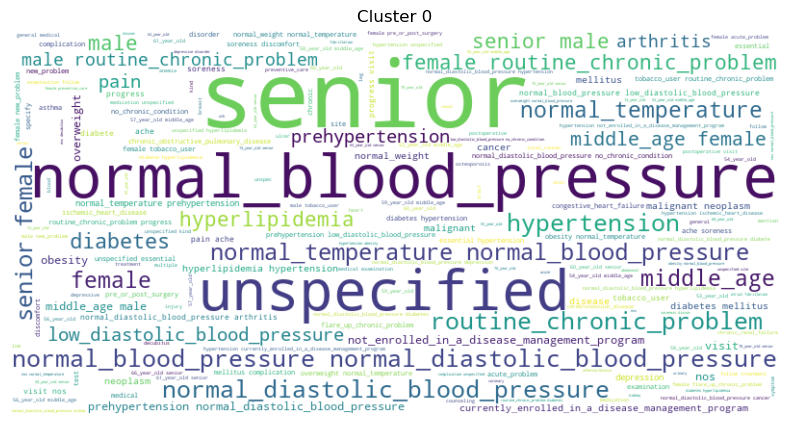

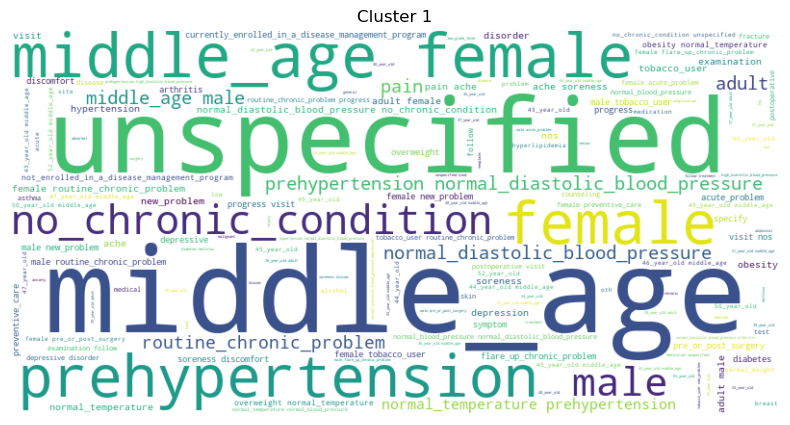

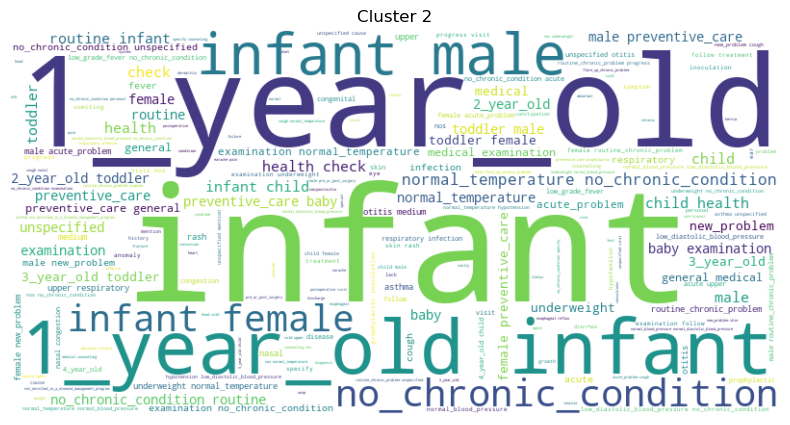

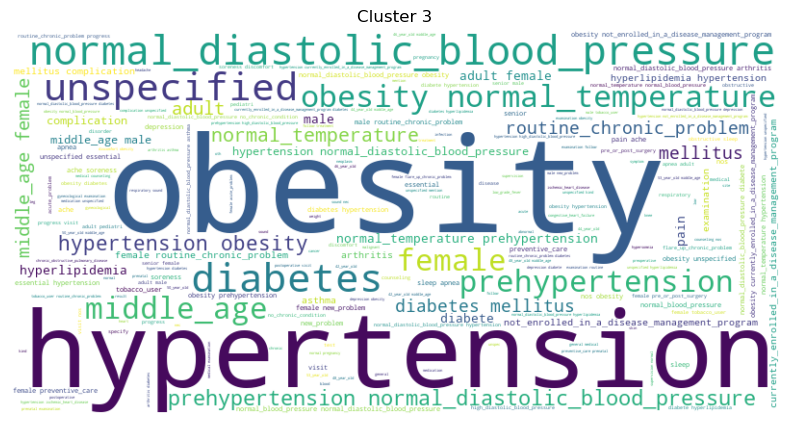

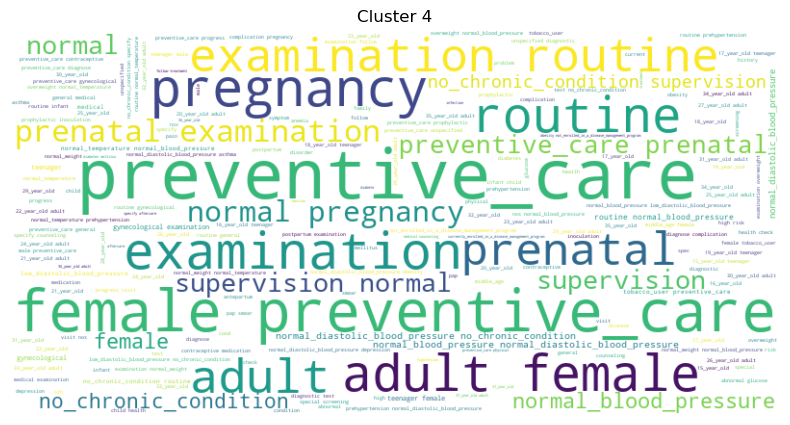

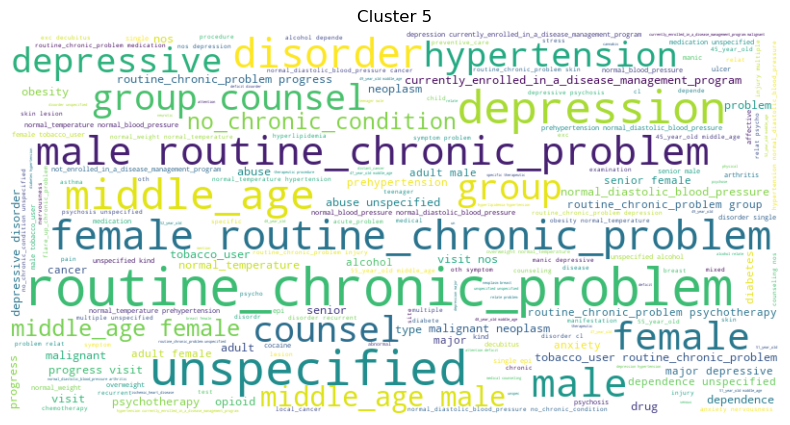

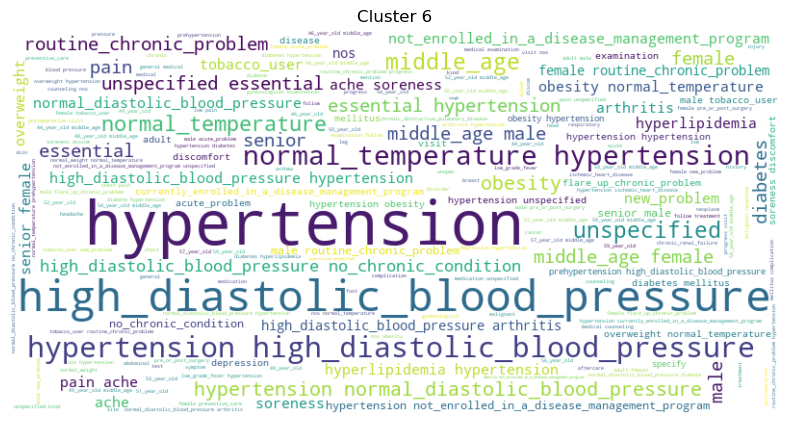

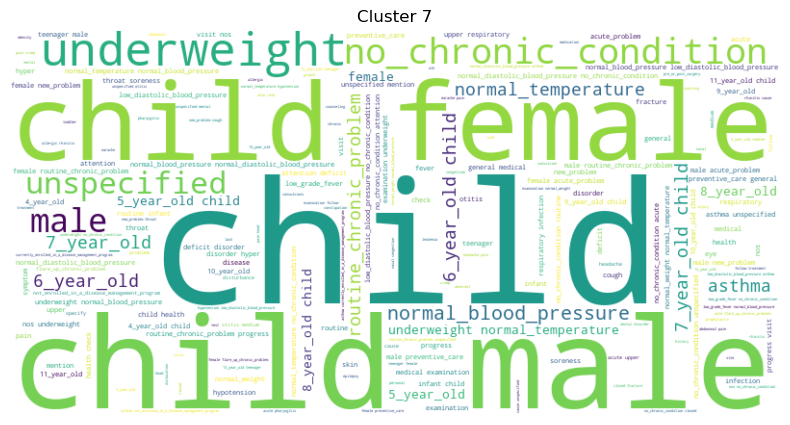

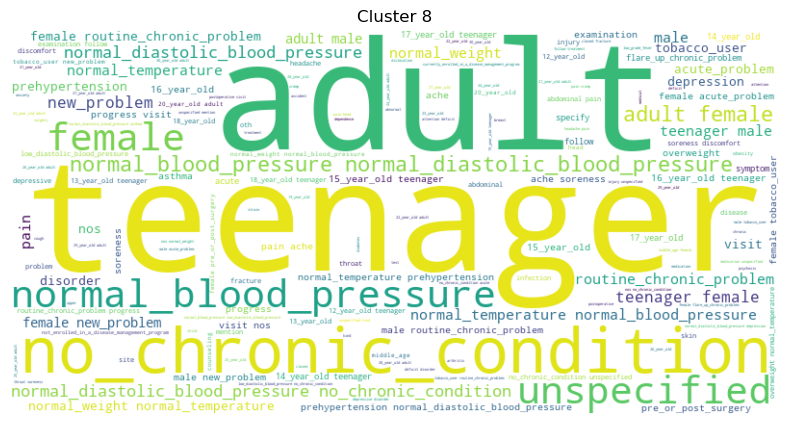

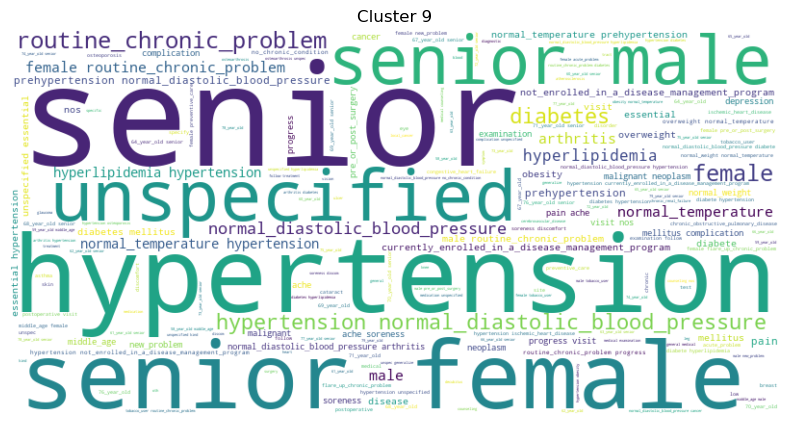

In [42]:
# Plot the word cloud for each cluster basd on the average TF-IDF
for i in range(n_clusters):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cluster_tfidf.loc[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}')
    plt.show()

## 6 - Topic modeling

In [43]:
import gensim
from gensim import corpora

random_seed = 42

In [44]:
# Generate bigrams
def generate_bigrams(row):
    tokens = row.split()
    bigram_model = gensim.models.Phrases(tokens, min_count=5, threshold=100)
    tokens = [token for token in bigram_model[tokens]]
    return tokens


print(generate_bigrams(train_df['ProcessedText'].iloc[0]))
preprocessed_docs = train_df['ProcessedText'].apply(generate_bigrams)

['55_year_old', 'middle_age', 'male', 'acute_problem', 'injury', 'unspecified', 'sho', 'obesity', 'normal_temperature', 'hypertension', 'high_diastolic_blood_pressure', 'diabetes', 'hyperlipidemia', 'obesity', 'currently_enrolled_in_a_disease_management_program', 'shoulder', 'upper', 'arm', 'injury']


In [45]:
# Build dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [73]:
# Train LDA model
n_topics = 5

lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics,
    random_state=random_seed,
    chunksize=100,
    passes=10,
)



### 6.1 - Visualize the topics

In [74]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()

In [75]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

/Users/sean7x/miniconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.073940  0.193188       1        1  30.738177
4     -0.102293  0.068997       2        1  20.860877
2      0.059237 -0.193069       3        1  19.263510
3     -0.258426 -0.041026       4        1  15.862107
0      0.227542 -0.028091       5        1  13.275329, topic_info=                      Term          Freq         Total Category  logprob  \
157                   pain  24841.000000  24841.000000  Default  30.0000   
7             hypertension  43333.000000  43333.000000  Default  29.0000   
126            examination  25696.000000  25696.000000  Default  28.0000   
183                   ache  11278.000000  11278.000000  Default  27.0000   
155                  child  12245.000000  12245.000000  Default  26.0000   
..                     ...           ...           ...      ...      ...   
25                  senior   2676.663252  21514.725705   Topic5  -4.4812   
62            tobacco_user   2159.226212  12230.442281   Topic5  -4.6960   
53                   adult   2349.060963  25692.427305   Topic5  -4.6118   
22   normal_blood_pressure   2015.922013  25651.675561   Topic5  -4.7647   
24              overweight   1567.265567   9691.667806   Topic5  -5.0165   

     loglift  
157  30.0000  
7    29.0000  
126  28.0000  
183  27.0000  
155  26.0000  
..       ...  
25   -0.0649  
62    0.2851  
53   -0.3729  
22   -0.5243  
24    0.1973  

[331 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
259       3  0.006498  10_year_old
259       4  0.992070  10_year_old
650       3  0.031758  11_year_old
650       4  0.967549  11_year_old
41        4  0.999807   1_year_old
...     ...       ...          ...
73        4  0.252555        visit
73        5  0.000208        visit
40        1  0.999328          w/o
40        5  0.000566          w/o
836       3  0.999202        wound

[443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

### 6.2 - Get the topic distribution for each cluster

In [48]:
# Get the topic distribution for each document 
def get_avg_topic_distribution(cluster_data, topic_distribution, num_topics):
    cluster_topics = np.zeros((len(cluster_data.index), num_topics))

    # Update the distribution with the actual values
    for i, doc_index in enumerate(cluster_data.index.tolist()):
        for topic, prob in topic_distribution[doc_index]:
            cluster_topics[i, topic] = prob

    avg_topic_dist = np.mean(cluster_topics, axis=0)
    return avg_topic_dist


topic_distribution = lda_model.get_document_topics(corpus, minimum_probability=0.0)
clusters = train_df.groupby('cluster').ProcessedText

cluster_topics = []
for cluster, data in clusters:
    avg_topic_dist = get_avg_topic_distribution(data, topic_distribution, lda_model.num_topics)
    cluster_topics.append([avg_topic_dist.tolist()])

cluster_topics_df = pd.DataFrame(cluster_topics, columns=['avg_topic_distribution'])

cluster_topics_df

,avg_topic_distribution
0,"[0.11192312818387876, 0.32442373159912086, 0.0..."
1,"[0.1530188503925319, 0.11960471933889641, 0.14..."
2,"[0.021416503396911885, 0.031177917313040905, 0..."
3,"[0.10588432719407163, 0.26655354816425836, 0.0..."
4,"[0.019878823143575555, 0.028744557614461052, 0..."
5,"[0.04133420605967969, 0.18364859356113758, 0.0..."
6,"[0.14623308541608243, 0.35757472763325354, 0.1..."
7,"[0.03583729479052634, 0.04662655876628964, 0.2..."
8,"[0.10013033642663802, 0.05111220742613668, 0.2..."
9,"[0.12009999880080202, 0.3754922701368711, 0.05..."


### 6.3 - Visualize the distribution of topics within each cluster

In [49]:
import altair as alt

In [50]:
# Reshape the dataframe to have a row for each cluster and topic
cluster_topics_heatmap_df = cluster_topics_df.avg_topic_distribution.apply(pd.Series).reset_index().rename(columns={'index': 'cluster'}).melt(id_vars='cluster', var_name='topic', value_name='probability')

heatmap = alt.Chart(cluster_topics_heatmap_df).mark_rect().encode(
    x='topic:O',
    y='cluster:O',
    color='probability:Q'
).properties(
    title='Average Topic Distribution for Each Cluster',
    width=400,
    height=400
)

heatmap

alt.Chart(...)